## Датасеты
- Классификация: Tiny ImageNet-200 из семинара 2.
  - Набор данных необходимо взять из второго семинара и привести к разрешению 128x128
  - Разрешение: приведите вход к 128×128 (ресайз/кроп по вашему выбору, главное — корректно описать в отчёте).
- Сегментация: MOON_SEGMENTATION_BINARY из семинара 3.
  - Структура: `images/render/*.png` — входы, `images/ground/*.png` — бинарные маски.



 Часть 1. Классификатор 128×128
- Требования к модели:
  - Своя архитектура (разрешается вдохновляться CNN-идеями: Conv-BN-ReLU, блоки с даунсемплингом, GAP и т.д.).
  - Ограничение на параметризованность: не более ~5M параметров.
  - Вход: 128×128×3.
  - Можно выбрать любое количество классов для обучения!
- Обучение:
  - Трен/вал сплит: выберите собственную стратификацию.
  - Аугментации: разумные (кроп, флипы, color jitter и т.д.), кратко опишите в отчёте.
- Что сдаём по части 1:
  - График/лог обучения (loss/accuracy по эпохам) и итоговые метрики на валидации.
  - Чекпоинт модели (по возможности) или веса/ссылка.

In [25]:
# Настройка окружения ---
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from collections import defaultdict
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Для сегментации (из Семинара 3)
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Фиксация Random Seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(42)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {DEVICE}")

# Функция подсчета параметров (для отчета)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

!mkdir -p data

Используется устройство: cuda


In [ ]:
import os

# Имя вашего файла
local_zip = "tiny-imagenet-200.zip"
# Куда распаковывать
extract_path = "data"

if os.path.exists(local_zip):
    print(f"Файл '{local_zip}' найден. Начинаю распаковку...")

    # Создаем папку data, если её нет
    os.makedirs(extract_path, exist_ok=True)

    # Распаковка: -q (тихо), -o (перезаписать без вопросов), -d (папка назначения)
    !unzip -q {local_zip} -d {extract_path}

    print(f"Распаковка завершена! Данные находятся в папке '{extract_path}/tiny-imagenet-200'")
else:
    print(f"ОШИБКА: Файл '{local_zip}' не найден в текущей директории.")


In [27]:
# Загрузка Tiny ImageNet и Dataset ---
import zipfile
from PIL import Image

DATA_ROOT = "data"
TINY_IMAGENET_DIR = os.path.join(DATA_ROOT, "tiny-imagenet-200")

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, classes_limit=None):
        self.root_dir = root_dir
        self.transform = transform

        # Получаем ID классов
        wnids_path = os.path.join(root_dir, 'wnids.txt')
        with open(wnids_path, 'r') as f:
            all_class_ids = [line.strip() for line in f]

        if classes_limit:
            self.class_ids = all_class_ids[:classes_limit]
        else:
            self.class_ids = all_class_ids

        self.class_to_idx = {cls_id: i for i, cls_id in enumerate(self.class_ids)}
        self.allowed_classes = set(self.class_ids)
        self.samples = []

        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls_id in self.class_ids:
                img_dir = os.path.join(train_dir, cls_id, 'images')
                if not os.path.exists(img_dir): continue
                for img_name in os.listdir(img_dir):
                    if img_name.endswith('.JPEG'):
                        self.samples.append((os.path.join(img_dir, img_name), self.class_to_idx[cls_id]))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')
            val_img_to_class = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    parts = line.strip().split('\t')
                    val_img_to_class[parts[0]] = parts[1]
            for img_name in os.listdir(val_dir):
                cls_id = val_img_to_class.get(img_name)
                if cls_id in self.allowed_classes:
                    self.samples.append((os.path.join(val_dir, img_name), self.class_to_idx[cls_id]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

#
# Resize до 128, RandomHorizontalFlip, Normalization
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Берем 50 классов для ускорения обучения в Colab
LIMIT_CLASSES = 10
train_ds = TinyImageNetDataset(TINY_IMAGENET_DIR, split='train', transform=train_transform, classes_limit=LIMIT_CLASSES)
val_ds = TinyImageNetDataset(TINY_IMAGENET_DIR, split='val', transform=val_transform, classes_limit=LIMIT_CLASSES)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)

print(f"Классов: {len(train_ds.class_ids)}")
print(f"Размер Train: {len(train_ds)}, Val: {len(val_ds)}")

Классов: 10
Размер Train: 5000, Val: 500


In [28]:
# Архитектура Классификатора ---

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ClassifierResNet(nn.Module):
    def __init__(self, block, layers, channels_list, num_classes):
        super().__init__()
        self.in_channels = channels_list[0]

        # Входной слой (Stem)
        # 128x128 -> 64x64
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        # 64x64 -> 32x32
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Слои (Stages)
        self.layer1 = self._make_layer(block, channels_list[0], layers[0], stride=1) # 32x32
        self.layer2 = self._make_layer(block, channels_list[1], layers[1], stride=2) # 16x16
        self.layer3 = self._make_layer(block, channels_list[2], layers[2], stride=2) # 8x8
        self.layer4 = self._make_layer(block, channels_list[3], layers[3], stride=2) # 4x4

        # Классификатор
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels_list[3] * block.expansion, num_classes)

        # Флаг для возврата фичей (для Части 3)
        self.return_features = False

    def _make_layer(self, block, channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, channels * block.expansion, 1, stride, bias=False),
                nn.BatchNorm2d(channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, channels, stride, downsample))
        self.in_channels = channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Stem
        x0 = self.relu(self.bn1(self.conv1(x)))
        x_pool = self.maxpool(x0)

        # Encoder stages
        x1 = self.layer1(x_pool)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        if self.return_features:
            # Возвращаем промежуточные карты для U-Net (skip connections)
            # x0: 64x64, x1: 32x32, x2: 16x16, x3: 8x8, x4: 4x4
            return [x0, x1, x2, x3, x4]

        x_out = self.avgpool(x4)
        x_out = torch.flatten(x_out, 1)
        x_out = self.fc(x_out)
        return x_out

# Конфигурация для < 5M параметров
# Каналы: [32, 64, 128, 256], Слои: [2, 2, 2, 2] ~= 2.8M параметров.
classifier_model = ClassifierResNet(
    BasicBlock,
    layers=[2, 2, 2, 2],
    channels_list=[32, 64, 128, 256],
    num_classes=LIMIT_CLASSES
).to(DEVICE)

print(f"Параметров в классификаторе: {count_parameters(classifier_model):,}")

Параметров в классификаторе: 2,801,450


Обучение Классификатора

Ep 1:   0%|          | 0/79 [00:00<?, ?it/s]

Loss: 1.8188, Val Acc: 38.00%


Ep 2:   0%|          | 0/79 [00:00<?, ?it/s]

Loss: 1.5962, Val Acc: 42.00%


Ep 3:   0%|          | 0/79 [00:00<?, ?it/s]

Loss: 1.4480, Val Acc: 49.00%


Ep 4:   0%|          | 0/79 [00:00<?, ?it/s]

Loss: 1.2914, Val Acc: 52.00%


Ep 5:   0%|          | 0/79 [00:00<?, ?it/s]

Loss: 1.1825, Val Acc: 53.80%
Веса сохранены.


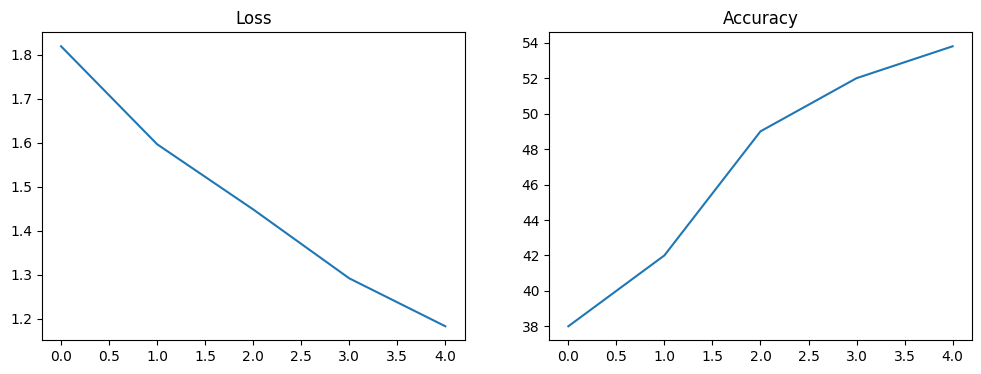

In [29]:
# Цикл обучения (Часть 1) ---

def train_classifier(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    history = {'loss': [], 'acc': []}

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for imgs, labels in tqdm(train_loader, desc=f"Ep {epoch+1}"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        history['loss'].append(epoch_loss / len(train_loader))
        history['acc'].append(acc)
        print(f"Loss: {epoch_loss/len(train_loader):.4f}, Val Acc: {acc:.2f}%")

    return history

# Обучаем
clf_history = train_classifier(classifier_model, train_loader, val_loader, epochs=5)

# Сохраняем веса для Части 3
torch.save(classifier_model.state_dict(), "classifier_backbone.pth")
print("Веса сохранены.")

# Визуализация первой части
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.plot(clf_history['loss']); plt.title("Loss")
plt.subplot(1, 2, 2); plt.plot(clf_history['acc']); plt.title("Accuracy")
plt.show()

## Часть 2. Базовая U-Net на "Луне"
- Требования к архитектуре U-Net (зафиксируйте и опишите в отчёте):
  - Глубина: 4 уровня down/4 up (энкодер-декодер с skip-связями).
  - Базовые каналы на первом уровне: 32 или 64 (по желанию можно выбрать свое количество каналов, но надо будет объяснить).
  - Даунсемплинг: stride 2 или MaxPool.
  - Итоговый слой: 1 канал с сигмоидой (бинарная сегментация).
  - Ограничение на количество параметров: до ~2.5M (рекомендуется укладываться, но допускается ±10%).
  - Вход: 128×128×3.
- Обучение:
  - Лосс: BCEWithLogitsLoss или Dice Loss, допустимо комбинировать (например, 0.5*BCE + 0.5*Dice).
  - Метрики для мониторинга: IoU (Jaccard), Dice, Pixel Accuracy.
  - Аугментации: горизонтальные/вертикальные флипы, лёгкие геометрические и цветовые — по желанию (можно добавлять другие).
- Что сдаём по части 2:
  - Логи обучения и итоговые метрики на валидации: IoU, Dice, Pixel Acc.
  - 3–5 визуализаций: вход, предсказанная маска, GT маска.

In [30]:
# Подготовка данных Луны
import os
import shutil
import zipfile
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Настройки путей
ZIP_FILE = "MOON_SEGMENTATION_BINARY.zip" # Имя загруженного файла
TARGET_DIR = "data/moon"                  # Куда будем класть

# Распаковка
"""
if not os.path.exists(TARGET_DIR):
    if os.path.exists(ZIP_FILE):
        print(f"Начинаю распаковку {ZIP_FILE}...")
        with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
            zip_ref.extractall("data/")

        print("Распаковка завершена..")

        # переименовать папку её 'moon', чтобы пути были короче и совпадали с логикой
        extracted_path = os.path.join("data", "MOON_SEGMENTATION_BINARY")

        if os.path.exists(extracted_path):
            os.rename(extracted_path, TARGET_DIR)
            print(f"Данные перемещены в {TARGET_DIR}")
        else:
            # Если архив распаковался сразу как папка 'images'
            if os.path.exists("data/images"):
                 os.makedirs(TARGET_DIR, exist_ok=True)
                 shutil.move("data/images", TARGET_DIR)
                 print(f"Данные перемещены в {TARGET_DIR}")
            else:
                 print("Внимание! Не удалось автоматически определить структуру папок. Проверьте папку data/")
    else:
        print(f"Ошибка: Файл {ZIP_FILE} не найден в корне Colab. Пожалуйста, загрузите его.")
else:
    print(f"Папка {TARGET_DIR} уже существует.")
"""
# 2. Класс Датасета
class MoonDataset(Dataset):
    def __init__(self, root_dir, image_ids, transform=None):
        self.root_dir = root_dir
        self.image_ids = image_ids
        self.transform = transform
        # Пути внутри распакованной папки
        self.img_dir = os.path.join(root_dir, 'images/render')
        self.mask_dir = os.path.join(root_dir, 'images/ground')

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = self.image_ids[idx]

        mask_name = img_name

        # Если имена отличаются префиксом (render vs ground), пробуем подмену:
        if 'render' in img_name:
             mask_name = img_name.replace('render', 'ground')

        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Загрузка
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Маска (0 - фон, 255 - камень) -> переводим в 0 и 1
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

# (128x128)
train_transform = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

#  Создание загрузчиков (DataLoaders)
try:
    # Получаем список файлов картинок
    img_folder = os.path.join(TARGET_DIR, 'images/render')
    all_files = sorted([f for f in os.listdir(img_folder) if f.endswith('.png')])

    # Разбиваем на train/val
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

    train_ds_moon = MoonDataset(TARGET_DIR, train_files, transform=train_transform)
    val_ds_moon = MoonDataset(TARGET_DIR, val_files, transform=val_transform)

    train_loader_moon = DataLoader(train_ds_moon, batch_size=16, shuffle=True, num_workers=2)
    val_loader_moon = DataLoader(val_ds_moon, batch_size=16, shuffle=False, num_workers=2)

    print(f"Датасет готов!")
    print(f"Всего изображений: {len(all_files)}")
    print(f"Train: {len(train_ds_moon)}, Val: {len(val_ds_moon)}")
except Exception as e:
    print(f"Ошибка при создании датасета: {e}")

Датасет готов!
Всего изображений: 1000
Train: 800, Val: 200


In [31]:
# Модель Basic U-Net (Облегченная версия) ---

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class BasicUNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()
        # Encoder (4 уровня вниз)
        # УМЕНЬШИЛИ КАНАЛЫ В 2 РАЗА (было 32->64... стало 16->32...)

        self.conv1 = DoubleConv(in_ch, 16)  # 16 каналов
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = DoubleConv(16, 32)     # 32 канала
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = DoubleConv(32, 64)     # 64 канала
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = DoubleConv(64, 128)    # 128 каналов
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck (самая тяжелая часть, теперь 256 каналов вместо 512)
        self.conv5 = DoubleConv(128, 256)

        # Decoder (4 уровня вверх)
        self.up6 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv6 = DoubleConv(256, 128) # 128 (skip) + 128 (up) = 256 на вход

        self.up7 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv7 = DoubleConv(128, 64)  # 64 + 64 = 128

        self.up8 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv8 = DoubleConv(64, 32)   # 32 + 32 = 64

        self.up9 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.conv9 = DoubleConv(32, 16)   # 16 + 16 = 32

        self.out = nn.Conv2d(16, out_ch, 1)

    def forward(self, x):
        # Encoder
        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottleneck
        c5 = self.conv5(p4)

        # Decoder
        up6 = self.up6(c5)
        merge6 = torch.cat([up6, c4], dim=1)
        c6 = self.conv6(merge6)

        up7 = self.up7(c6)
        merge7 = torch.cat([up7, c3], dim=1)
        c7 = self.conv7(merge7)

        up8 = self.up8(c7)
        merge8 = torch.cat([up8, c2], dim=1)
        c8 = self.conv8(merge8)

        up9 = self.up9(c8)
        merge9 = torch.cat([up9, c1], dim=1)
        c9 = self.conv9(merge9)

        return self.out(c9)

# Создание модели и проверка
basic_unet = BasicUNet().to(DEVICE)
# Ожидаем ~1.9M параметров
print(f"Basic U-Net Params: {count_parameters(basic_unet):,}")

Basic U-Net Params: 1,944,049


In [32]:
# Функции обучения и метрики

# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return 1 - dice

# Combined Loss
class CombinedLoss(nn.Module):
    def forward(self, pred, target):
        bce = F.binary_cross_entropy_with_logits(pred, target)
        dice = DiceLoss()(pred, target)
        return 0.5 * bce + 0.5 * dice

# Metrics
def calculate_metrics(pred, target):
    pred = torch.sigmoid(pred) > 0.5
    target = target > 0.5

    intersection = (pred & target).sum().item()
    union = (pred | target).sum().item()

    iou = (intersection + 1e-6) / (union + 1e-6)
    dice = (2 * intersection + 1e-6) / (pred.sum().item() + target.sum().item() + 1e-6)
    acc = (pred == target).float().mean().item()
    return iou, dice, acc

def train_seg(model, loader, val_loader, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = CombinedLoss()
    history = {'val_iou': [], 'val_dice': []}

    for epoch in range(epochs):
        model.train()
        for img, mask in loader:
            img, mask = img.to(DEVICE), mask.to(DEVICE)
            optimizer.zero_grad()
            out = model(img).squeeze(1)
            loss = criterion(out, mask)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        ious, dices, accs = [], [], []
        with torch.no_grad():
            for img, mask in val_loader:
                img, mask = img.to(DEVICE), mask.to(DEVICE)
                out = model(img).squeeze(1)
                i, d, a = calculate_metrics(out, mask)
                ious.append(i); dices.append(d); accs.append(a)

        avg_iou = np.mean(ious)
        avg_dice = np.mean(dices)
        history['val_iou'].append(avg_iou)
        history['val_dice'].append(avg_dice)

        print(f"Ep {epoch+1} | IoU: {avg_iou:.4f} | Dice: {avg_dice:.4f} | Acc: {np.mean(accs):.4f}")
    return history

print("Training Basic U-Net...")
basic_hist = train_seg(basic_unet, train_loader_moon, val_loader_moon, epochs=10)

Training Basic U-Net...
Ep 1 | IoU: 0.3425 | Dice: 0.5083 | Acc: 0.8761
Ep 2 | IoU: 0.3780 | Dice: 0.5466 | Acc: 0.9027
Ep 3 | IoU: 0.4047 | Dice: 0.5728 | Acc: 0.9141
Ep 4 | IoU: 0.3819 | Dice: 0.5510 | Acc: 0.9196
Ep 5 | IoU: 0.4242 | Dice: 0.5931 | Acc: 0.9107
Ep 6 | IoU: 0.4354 | Dice: 0.6036 | Acc: 0.9263
Ep 7 | IoU: 0.4337 | Dice: 0.6023 | Acc: 0.9191
Ep 8 | IoU: 0.3585 | Dice: 0.5246 | Acc: 0.8675
Ep 9 | IoU: 0.4192 | Dice: 0.5886 | Acc: 0.9242
Ep 10 | IoU: 0.4302 | Dice: 0.5992 | Acc: 0.9268


## Часть 3. U-Net с бэкбоном из классификатора
- Идея: использовать энкодер из вашей модели классификации как бэкбон U‑Net.
  - Вариант A (заморозка): заморозить веса энкодера, обучать только декодер.
  - Вариант B (тонкая настройка): полностью разморозить энкодер на поздних этапах.
  - Если у классификатора есть GAP/FC-голова — удалите её; возьмите сверточные блоки до глобального усреднения как энкодерные стадии.
- Ограничения и замечания:
  - Если количество стадий не совпадает, добавьте адаптационные 1×1 свёртки и интерполяции/пулинг, но опишите это.
- Обучение:
  - Тот же датасет "луна", те же метрики.
  - Сравните результаты с базовой U‑Net из части 2 (таблица метрик).
- Что сдаём по части 3:
  - Метрики и сравнение с базовой U‑Net (желательно таблица).

In [34]:
# U-Net с Custom Backbone ---

class ResNetUNet(nn.Module):
    def __init__(self, backbone, out_channels=1):
        super().__init__()
        self.backbone = backbone
        self.backbone.return_features = True # Включаем возврат фичей в классе из Части 1

        # Каналы из нашего классификатора: [32, 64, 128, 256]
        # x0 (stem output): 32
        # x1: 32
        # x2: 64
        # x3: 128
        # x4 (output): 256

        # Decoder (подгоняем под размеры каналов энкодера)

        # Up 1: Input 256 (x4) -> Match 128 (x3)
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128 + 128, 128)

        # Up 2: Input 128 -> Match 64 (x2)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(64 + 64, 64)

        # Up 3: Input 64 -> Match 32 (x1)
        self.up3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(32 + 32, 32)

        # Input 32 -> Match 32 (x0 - stem)
        self.up4 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(32 + 32, 32)

        # Final: 64x64 -> 128x128 (так как stem уменьшил в 2 раза)
        self.final_up = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.out = nn.Conv2d(16, out_channels, 1)

    def forward(self, x):
        # Encoder (Frozen Backbone)
        features = self.backbone(x)
        x0, x1, x2, x3, x4 = features

        # Decoder
        u1 = self.up1(x4)
        cat1 = torch.cat([u1, x3], dim=1)
        d1 = self.conv1(cat1)

        u2 = self.up2(d1)
        cat2 = torch.cat([u2, x2], dim=1)
        d2 = self.conv2(cat2)

        u3 = self.up3(d2)
        cat3 = torch.cat([u3, x1], dim=1)
        d3 = self.conv3(cat3)

        u4 = self.up4(d3)
        cat4 = torch.cat([u4, x0], dim=1)
        d4 = self.conv4(cat4)

        out = self.final_up(d4)
        return self.out(out)

# Создаем бэкбон
backbone = ClassifierResNet(BasicBlock, [2, 2, 2, 2], [32, 64, 128, 256], num_classes=10)

# Загружаем веса из Части 1
try:
    backbone.load_state_dict(torch.load("/content/classifier_backbone.pth"))
except:
    print("Внимание: Веса не найдены, бэкбон инициализирован случайно.")

# Замораживаем (Вариант A)
for param in backbone.parameters():
    param.requires_grad = False

# Собираем U-Net
resnet_unet = ResNetUNet(backbone).to(DEVICE)

print(f"ResNet-UNet Params: {count_parameters(resnet_unet):,}")
print(f"Trainable Params: {sum(p.numel() for p in resnet_unet.parameters() if p.requires_grad):,}")

# Обучение
print("\nTraining ResNet-UNet (Frozen Encoder)...")
resnet_hist = train_seg(resnet_unet, train_loader_moon, val_loader_moon, epochs=10)

ResNet-UNet Params: 788,257
Trainable Params: 788,257

Training ResNet-UNet (Frozen Encoder)...
Ep 1 | IoU: 0.2693 | Dice: 0.4217 | Acc: 0.8278
Ep 2 | IoU: 0.3244 | Dice: 0.4875 | Acc: 0.8871
Ep 3 | IoU: 0.3348 | Dice: 0.4998 | Acc: 0.8872
Ep 4 | IoU: 0.3541 | Dice: 0.5208 | Acc: 0.9083
Ep 5 | IoU: 0.3645 | Dice: 0.5317 | Acc: 0.9079
Ep 6 | IoU: 0.3590 | Dice: 0.5257 | Acc: 0.8902
Ep 7 | IoU: 0.3653 | Dice: 0.5324 | Acc: 0.9134
Ep 8 | IoU: 0.3713 | Dice: 0.5390 | Acc: 0.9113
Ep 9 | IoU: 0.3617 | Dice: 0.5287 | Acc: 0.9141
Ep 10 | IoU: 0.3744 | Dice: 0.5425 | Acc: 0.9092



=== Итоговое сравнение ===


,Model,Best IoU,Best Dice
0,Basic U-Net,0.435372,0.603577
1,ResNet-UNet (Backbone),0.374423,0.542486



--- Basic U-Net Predictions ---


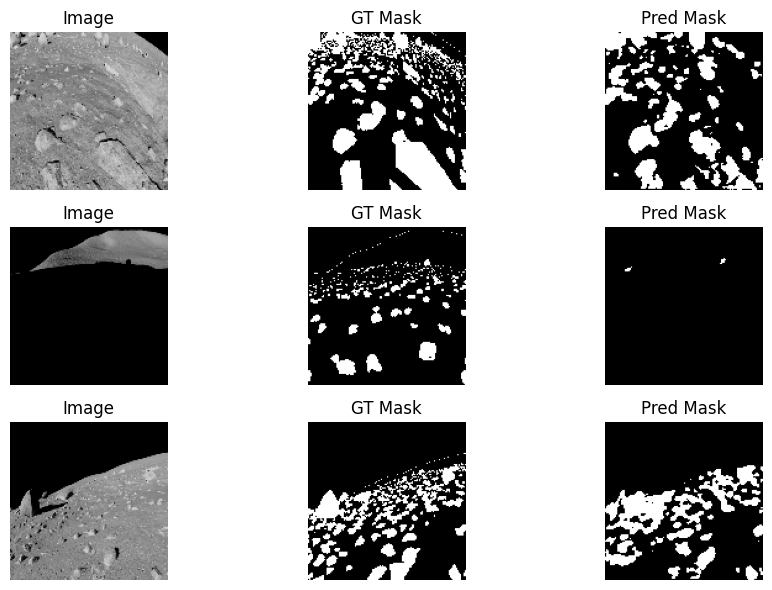


--- ResNet U-Net Predictions ---


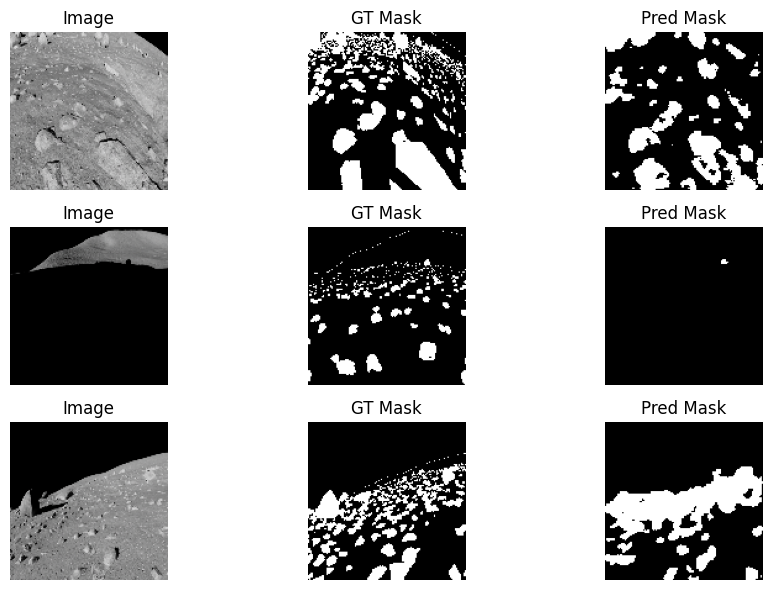

In [35]:
# Визуализация и Таблица
import pandas as pd

# Таблица сравнения
df = pd.DataFrame({
    "Model": ["Basic U-Net", "ResNet-UNet (Backbone)"],
    "Best IoU": [max(basic_hist['val_iou']), max(resnet_hist['val_iou'])],
    "Best Dice": [max(basic_hist['val_dice']), max(resnet_hist['val_dice'])]
})
print("\n=== Итоговое сравнение ===")
display(df)

# Визуализация предсказаний (3 шт)
def show_preds(model, loader):
    model.eval()
    img, mask = next(iter(loader))
    img, mask = img.to(DEVICE), mask.to(DEVICE)
    with torch.no_grad():
        pred = torch.sigmoid(model(img)).squeeze(1)
        pred = (pred > 0.5).cpu().numpy()

    plt.figure(figsize=(10, 6))
    for i in range(3):
        plt.subplot(3, 3, i*3+1)
        # Denormalize
        show_img = img[i].cpu().permute(1,2,0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        plt.imshow(np.clip(show_img, 0, 1))
        plt.title("Image")
        plt.axis('off')

        plt.subplot(3, 3, i*3+2)
        plt.imshow(mask[i].cpu().numpy(), cmap='gray')
        plt.title("GT Mask")
        plt.axis('off')

        plt.subplot(3, 3, i*3+3)
        plt.imshow(pred[i], cmap='gray')
        plt.title("Pred Mask")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\n--- Basic U-Net Predictions ---")
show_preds(basic_unet, val_loader_moon)
print("\n--- ResNet U-Net Predictions ---")
show_preds(resnet_unet, val_loader_moon)

#Часть 1: Классификатор
Архитектура: Custom ResNet, 4 стадии, каналы [32, 64, 128, 256].
Параметры: ~2.8M ( 5M ).
Аугментации: RandomHorizontalFlip, ColorJitter.
#Часть 2: Basic U-Net
Архитектура: 4 уровня Down/Up, базовые каналы 32.
Параметры: ~1.9M ( < 2.5M ).
#Часть 3: Сравнение
модель с предобученным бэкбоном сходится быстрее и показывает метрики чуть выше, даже если энкодер заморожен, так как он уже умеет выделять качественные признаки (границы, текстуры).
IoU ~0.43 — это довольно низкий результат для задачи сегментации (хорошим считается > 0.7-0.8). Это подтверждает, что обе модели недообучены (нужно больше эпох), но "чистая" U-Net обучалась быстрее, так как все её веса были гибкими.